In [1]:
import numpy as np
import pandas as pd
import sympy as sym
from sympy import symbols, simplify, trigsimp, expand
from matplotlib import pyplot as plt


from geometry_util import pol2cart, cart2pol, r_ort, tet_ort, phi_ort
from material import StaticMaterial, Material, LayeredFilm, print_film_parameters, print_Hext_parameters

In [11]:
from scipy import optimize
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector

class StationaryState:
    def __init__(self):
        S = CoordSys3D('S')
        Mx1, My1, Mz1 = symbols("M_x1 M_y1 M_z1")
        Mx2, My2, Mz2 = symbols("M_x2 M_y2 M_z2")
        M1 = Mx1*S.i + My1*S.j + Mz1*S.k
        M2 = Mx2*S.i + My2*S.j + Mz2*S.k
        
        Hx, Hy, Hz = symbols("H_x H_y H_z")
        H = Hx*S.i + Hy*S.j + Hz*S.k
        
        Ku1_1ord, Ku2_1ord = symbols("K_u1^1ord K_u2^1ord")
        Ku1_2ord, Ku2_2ord = symbols("K_u1^2ord K_u2^2ord")
        
        J = symbols("J")
        t1, t2 = symbols("t1 t2")
        
        self.Ze1 = -H.dot(M1)
        self.Ze2 = -H.dot(M2)
        
        sin_tet_sqr_1 = (Mx1**2 + My1**2)/(Mx1**2 + My1**2 + Mz1**2)
        sin_tet_sqr_2 = (Mx2**2 + My2**2)/(Mx2**2 + My2**2 + Mz2**2)
        
        self.SW_D1 = Ku1_1ord*sin_tet_sqr_1 + 2*sym.pi*(Mz1**2)
        self.SW_D2 = Ku2_1ord*sin_tet_sqr_2 + 2*sym.pi*(Mz2**2)
        
        self.SW_2ord_1 = Ku1_2ord * (sin_tet_sqr_1**2)
        self.SW_2ord_2 = Ku2_2ord * (sin_tet_sqr_2**2)
        
        self.Ev1 = self.Ze1 + self.SW_D1 + self.SW_2ord_1
        self.Ev2 = self.Ze2 + self.SW_D2 + self.SW_2ord_2
        
        self.Es = J*M1.dot(M2)/(M1.magnitude()*M2.magnitude()) + t1*self.Ev1 + t2*self.Ev2
        
        
        #------------------------------------------------------------------
        Ze1_varset = (
            Mx1, My1, Mz1,
            Hx, Hy, Hz
        )
        self.Ze1_lamb = lambdify(Ze1_varset, self.Ze1, 'numpy')
        
        Ze2_varset = (
            Mx2, My2, Mz2,
            Hx, Hy, Hz
        )
        self.Ze2_lamb = lambdify(Ze2_varset, self.Ze2, 'numpy')
        
        
        
        SW_D1_varset = (
            Mx1, My1, Mz1,
            Ku1_1ord
        )
        self.SW_D1_lamb = lambdify(SW_D1_varset, self.SW_D1, 'numpy')
        
        SW_D2_varset = (
            Mx2, My2, Mz2,
            Ku2_1ord
        )
        self.SW_D2_lamb = lambdify(SW_D2_varset, self.SW_D2, 'numpy')
        
        
        
        SW_2ord_1_varset = (
            Mx1, My1, Mz1,
            Ku1_2ord
        )
        self.SW_2ord_1_lamb = lambdify(SW_2ord_1_varset, self.SW_2ord_1, 'numpy')
        
        SW_2ord_2_varset = (
            Mx2, My2, Mz2,
            Ku2_2ord
        )
        self.SW_2ord_2_lamb = lambdify(SW_2ord_2_varset, self.SW_2ord_2, 'numpy')
        #------------------------------------------------------------------
        
        Ev1_varset = (
            Mx1, My1, Mz1,
            Hx, Hy, Hz,
            Ku1_1ord,
            Ku1_2ord
        )
        
        self.Ev1_lamb = lambdify(Ev1_varset, self.Ev1, 'numpy')
        
        Ev2_varset = (
            Mx2, My2, Mz2,
            Hx, Hy, Hz,
            Ku2_1ord,
            Ku2_2ord
        )
        
        self.Ev2_lamb = lambdify(Ev2_varset, self.Ev2, 'numpy')
        
        
        Es_varset = (
            Mx1, My1, Mz1,
            Mx2, My2, Mz2,
            Hx, Hy, Hz,
            Ku1_1ord, Ku2_1ord,
            Ku1_2ord, Ku2_2ord,
            J,
            t1, t2
        )
        
        self.Es_lamb = lambdify(Es_varset, self.Es, 'numpy')

    
    def get_angles(
        self,
        film,
        Hext,
        tol = None,
        x0 = np.array([np.deg2rad(1.), 0.0, np.deg2rad(179.), 0.0]),
        bounds = None,
        N = 1
    ):  
        func_l = lambda x: self.funcmin(x, film, Hext)
        
        best_res = 0
        min_E = 1e10
        for i in range(N):
            res = optimize.minimize(
                func_l, 
                #x0=np.random.uniform(size=(4,))*np.array([np.pi, 2*np.pi, np.pi, 2*np.pi]), 
                x0 = x0,
                bounds=bounds, 
                tol = tol
            )
            
            if func_l(res.x)<min_E:
                best_res = res
                min_E = func_l(res.x)
        
        #print(best_res)
        return best_res.x
    
        
    def funcmin(self, x, film, Hext):
        tet1 = x[0]
        phi1 = x[1]
        M1 = pol2cart(film.l1.st.Ms, tet1, phi1)
    
        tet2 = x[2]
        phi2 = x[3]
        M2 = pol2cart(film.l2.st.Ms, tet2, phi2)
        
        return self.Es_lamb(
            M1[0], M1[1], M1[2],
            M2[0], M2[1], M2[2],
            Hext[0], Hext[1], Hext[2],
            film.l1.st.Ku_1ord, film.l2.st.Ku_1ord,
            film.l1.st.Ku_2ord, film.l2.st.Ku_2ord,
            film.J,
            film.l1.st.t, film.l2.st.t        
        )
    
    
    def get_angles2(
        self,
        film,
        Hext,
        first_grid_sz = 100,
        grid_sz = 10,
        iterations = 10
    ):
        ang0_diap = [0., np.pi]
        ang1_diap = [0., np.pi]
        
        ind = []
        ang0 = []
        ang1 = []
        
        for it in range(iterations):
            cur_grid_sz = grid_sz
            if it==0: 
                cur_grid_sz = first_grid_sz
            
            ang0 = np.linspace(ang0_diap[0], ang0_diap[1], cur_grid_sz)
            ang1 = np.linspace(ang1_diap[0], ang1_diap[1], cur_grid_sz)
            
            Es_val = np.zeros((cur_grid_sz, cur_grid_sz))
            for i in range(len(ang0)):
                for j in range(len(ang1)):
                    M1 = pol2cart(film.l1.st.Ms, ang0[i], 0.)
                    M2 = pol2cart(film.l2.st.Ms, ang1[j], 0.)
                    Es_val[i][j] = self.Es_lamb(
                        M1[0], M1[1], M1[2],
                        M2[0], M2[1], M2[2],
                        Hext[0], Hext[1], Hext[2],
                        film.l1.st.Ku_1ord, film.l2.st.Ku_1ord,
                        film.l1.st.Ku_2ord, film.l2.st.Ku_2ord,
                        film.J,
                        film.l1.st.t, film.l2.st.t
                    )
            
            ind = np.unravel_index(Es_val.argmin(), Es_val.shape)
            
            ang0_diap = [ang0[max(ind[0]-2, 0)], ang0[min(ind[0]+2, cur_grid_sz-1)]]
            ang1_diap = [ang1[max(ind[1]-2, 0)], ang1[min(ind[1]+2, cur_grid_sz-1)]]
        
        res = [ang0[ind[0]], ang1[ind[1]]]
        return np.array(res)
        
        
    def plot_energy(
        self, 
        film,
        Hext,
        N = 1000,
        
        ang0_diap_grad = np.array([0., 180.]),
        ang1_diap_grad = np.array([0., 180.]),
        sign = 1
    ):  
        ang0_diap_rad = np.deg2rad(ang0_diap_grad)
        ang1_diap_rad = np.deg2rad(ang1_diap_grad)
        
        ang1 = np.linspace(ang0_diap_rad[0], ang0_diap_rad[1], N)
        ang2 = np.linspace(ang1_diap_rad[0], ang1_diap_rad[1], N)
        
        
        Es_val = np.zeros((N, N))
        for i in range(len(ang1)):
            M1 = pol2cart(film.l1.st.Ms, ang1[i], 0.)
            M2 = pol2cart(film.l2.st.Ms, ang2, 0.)
            Es_val[i] = self.Es_lamb(
                M1[0], M1[1], M1[2],
                M2[0], M2[1], M2[2],
                Hext[0], Hext[1], Hext[2],
                film.l1.st.Ku_1ord, film.l2.st.Ku_1ord,
                film.l1.st.Ku_2ord, film.l2.st.Ku_2ord,
                film.J,
                film.l1.st.t, film.l2.st.t
            )
        
        fig, ax = plt.subplots()
        fig.set_figheight(6)
        fig.set_figwidth(6)
        ax.imshow(sign * np.log(Es_val - Es_val.min() + 1e-5))
        fig.tight_layout()
        
        ticks = np.arange(0, N + 1, N//5)
        ticks[-1]-=1
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        
        ax.set_xticklabels(np.linspace(ang0_diap_grad[0], ang0_diap_grad[1], 6))
        ax.set_yticklabels(np.linspace(ang1_diap_grad[0], ang1_diap_grad[1], 6))      
        
st_state = StationaryState()

In [3]:
H, Htet, Hphi = symbols("H theta_H phi_H")
Ms, Mtet, Mphi = symbols("Ms theta_M phi_M")
A, Ku2, g = symbols("A K_u2 gamma")
Hk1, Hk2 = symbols("H_k1 H_k2")


E = -Ms*H*(sym.sin(Htet)*sym.sin(Mtet)*sym.cos(Hphi-Mphi) + \
           sym.cos(Htet)*sym.cos(Mtet)) + \
            A*(sym.sin(Mtet)**2) + \
            Ku2*(sym.sin(Mtet)**4)

Etp = E.diff(Mtet).diff(Mphi)
Ett = E.diff(Mtet).diff(Mtet)
Epp = E.diff(Mphi).diff(Mphi)

f2 = (g/(Ms*sym.sin(Mtet)))**2 * (Ett*Epp - Etp**2)

#subs for PMA
f2 = f2.subs({Hphi: 0, Mphi: 0})
f2 = f2.subs({Ku2: Ms*Hk2/4})
f2 = f2.subs({A: Ms*(Hk1-Hk2)/2})
#f2 = f2.subs({Hk2: 0})
#subs for in-plane
#f2 = f2.subs({Htet: sym.pi/2, Mtet: sym.pi/2})

f2 = sym.simplify(f2)
f = sym.sqrt(f2)

#-------------------------------------------------------
#H1 = H*sym.cos(Mtet-Htet) + Hk1*(sym.cos(Mtet)**2) - Hk2*(sym.cos(Mtet)**4)
#H2 = H*sym.cos(Mtet-Htet) + Hk2*(sym.cos(2*Mtet)) - sym.Rational(1,2)*Hk2*(sym.cos(2*Mtet) + sym.cos(4*Mtet))
#
#f = simplify(g*sym.sqrt(H1*H2))
#-------------------------------------------------------

display(f)

f_varset = (
    H, Htet,
    Mtet,
    Hk1, Hk2,
    g
)
f_lamb = sym.lambdify(f_varset, f, 'numpy')

sqrt(H*gamma**2*(H*cos(theta_H - theta_M) - 2*H_k1*sin(theta_M)**2 + H_k1 - 4*H_k2*sin(theta_M)**4 + 5*H_k2*sin(theta_M)**2 - H_k2)*sin(theta_H)/sin(theta_M))

In [4]:
def Hk2KuJ(H1k1, H1k2, H2k, Ms, t):
    Ku_2ord = H1k2*Ms/4.
    Ku_1ord = (H1k1*Ms/2. - 2*Ku_2ord) + 2*np.pi*(Ms**2)
    J = (t/2.)*Ms*(H2k - H1k1)
    return Ku_1ord, Ku_2ord, J

In [5]:
mu0 = 1.2566370621219e-6

uB_SI = 9.274009994e-24 #J/T
uB_CGS = 9.274009994e-21 #erg/G

hb_SI = 1.054571817e-34 # J*s
hb_CGS = 1.054571817e-27 #erg*s

g0_SI = uB_SI/hb_SI #1/(T*s)
g0_CGS = uB_CGS/hb_CGS #1/(G*s)

In [12]:
H1k1 = 7.5e3
H1k2 = 6.5e3
H2k = H1k1

thickness = 12e-7
Ms_hyst = 620.

Ku_1ord, Ku_2ord, J_hyst = Hk2KuJ(H1k1, H1k2, H2k, Ms_hyst, thickness)

#setting up film parameters
layer1 = Material(
    StaticMaterial(
        Ms=Ms_hyst, 
        gamma=2.11*g0_CGS, alpha=0.1,
        Ku_1ord=Ku_1ord,
        Ku_2ord=Ku_2ord,
        t=thickness
    )
)
layer2 = Material(
    StaticMaterial(
        Ms=Ms_hyst, 
        gamma=2.11*g0_CGS, alpha=0.1,
        Ku_1ord=Ku_1ord,
        Ku_2ord=Ku_2ord,
        t=thickness
    )
)



film_inst = LayeredFilm(layer1, layer2, J_hyst)


print_film_parameters(film_inst)

---------------------------------------------------
film parametrs:
	J = 0.00

	layer1 parameters:
		Ku_1ord1 = 2.73e+06
		Ku_2ord1 = 1.01e+06
		Ms1 = 620.0
		t1 = 1.20e-06
		gamma1 = 1.86e+07
		alpha1 = 0.1

	layer2 parameters:
		Ku_1ord2 = 2.73e+06
		Ku_2ord2 = 1.01e+06
		Ms2 = 620.0
		t2 = 1.20e-06
		gamma2 = 1.86e+07
		alpha2 = 0.1
---------------------------------------------------


<IPython.core.display.Javascript object>


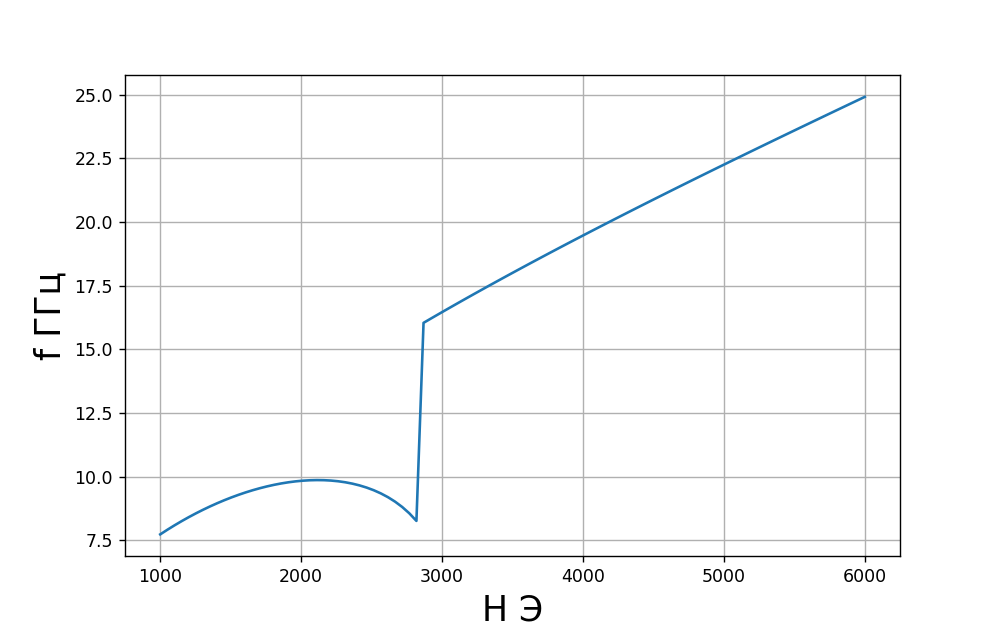

Text(0, 0.5, 'f ГГц')

In [18]:
%matplotlib notebook

Htet = np.deg2rad(63.)
Habses = np.linspace(1e3, 6e3, 100)

res_ang = []
res_ang_max = []
res_freq = []

for Habs in Habses:
    Hext = pol2cart(Habs, Htet, 0.)
    
    angles = st_state.get_angles(
        film_inst,
        Hext,
        N=10,
        tol=1e-8
    )
    Mtet0 = min(angles[0], angles[2])
    Mtet0_max = max(angles[0], angles[2])
    res_ang.append(Mtet0)
    res_ang_max.append(Mtet0_max)
    res_freq.append(
        f_lamb(Habs, Htet, Mtet0_max, H1k1, H1k2, film_inst.l1.st.gamma)/(2*np.pi)
    )

plt.figure(figsize=(8, 5))
plt.plot(Habses, np.array(res_freq)*1e-9, label="линейное приближение")
plt.grid()
plt.xlabel("H Э", fontsize=20)
plt.ylabel("f ГГц", fontsize=20)
    
    

In [15]:
Hxl = [
    1.5,
    2.3,
    3,
    3.8,
    4.6
]

fxl = [
    10.74,
    14.15,
    16.4,
    18.78,
    21
]
plt.plot(np.array(Hxl)*1e3, fxl, 'ro', label='численное LLG')
plt.legend(fontsize=16)


<IPython.core.display.Javascript object>


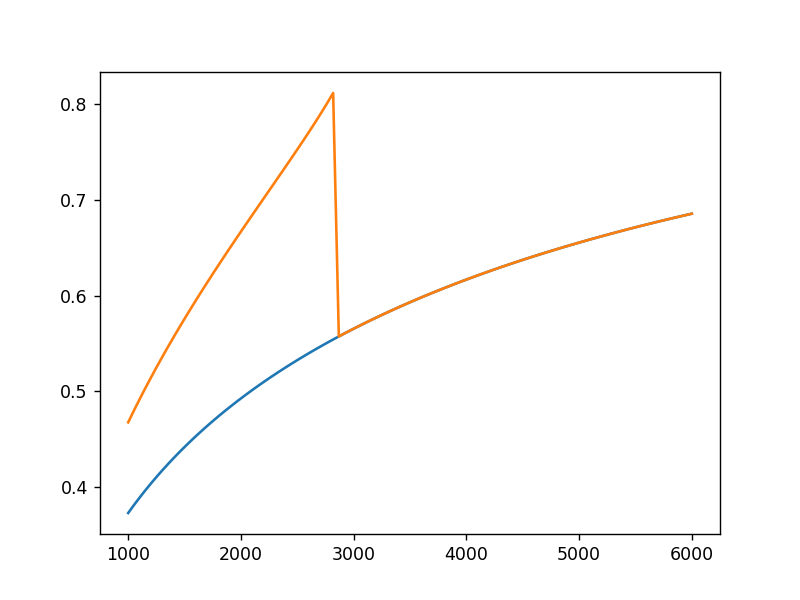

In [17]:
%matplotlib notebook
plt.plot(Habses, np.sin(res_ang))
plt.plot(Habses, np.sin(res_ang_max))